In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import zipfile
import os

zip_file_path = '/content/gdrive/MyDrive/vison_data/archive.zip'
extract_dir = '/content/vison_data' # You can change this to your desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to: {extract_dir}")

File extracted to: /content/vison_data


In [4]:
# Step 2: Set paths
import os
import json
import random
from collections import Counter

dataset_dir = "/content/vison_data/flickr30k_images/flickr30k_images"
coco_json_path = "/content/gdrive/MyDrive/vison_data/coco_output_fixed.json"
output_dir = "/content/coco_dataset"

os.makedirs(output_dir, exist_ok=True)


In [5]:
import json
import os
import shutil
import random
from tqdm import tqdm
from collections import Counter, defaultdict

# === Paths ===
full_json_path = "/content/gdrive/MyDrive/vison_data/coco_output.json"
source_img_dir = "/content/vison_data/flickr30k_images/flickr30k_images"
output_dir = "/content/coco_dataset"

train_img_dir = os.path.join(output_dir, "images/train")
val_img_dir = os.path.join(output_dir, "images/val")
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

# === Load Full COCO JSON ===
with open(full_json_path, "r") as f:
    coco_data = json.load(f)

images = coco_data["images"]
annotations = coco_data["annotations"]
categories = coco_data["categories"]

# Map category_id to name for clarity
id_to_class = {cat["id"]: cat["name"] for cat in categories}

# === Split Images ===
random.seed(42)
random.shuffle(images)
split_idx = int(len(images) * 0.8)
train_images = images[:split_idx]
val_images = images[split_idx:]

train_ids = {img["id"] for img in train_images}
val_ids = {img["id"] for img in val_images}

train_annotations = [ann for ann in annotations if ann["image_id"] in train_ids]
val_annotations = [ann for ann in annotations if ann["image_id"] in val_ids]

# === Count annotations per class ===
def count_classes(annotations):
    class_counter = Counter()
    for ann in annotations:
        class_name = id_to_class[ann["category_id"]]
        class_counter[class_name] += 1
    return class_counter

train_counts = count_classes(train_annotations)
val_counts = count_classes(val_annotations)

print("\n📊 Annotation Counts:")
print("Train:", train_counts)
print("Val:  ", val_counts)

# === Calculate Class Weights (Inverse frequency)
def calc_weights(counter):
    total = sum(counter.values())
    weights = {cls: round(total / count, 2) for cls, count in counter.items()}
    return weights

weights = calc_weights(train_counts)
print("\n⚖️ Class Weights (for loss):")
for cls, w in weights.items():
    print(f"{cls}: {w}")

# === Save JSONs ===
train_json = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories
}
val_json = {
    "images": val_images,
    "annotations": val_annotations,
    "categories": categories
}

with open(os.path.join(output_dir, "annotations_train.json"), "w") as f:
    json.dump(train_json, f, indent=2)
with open(os.path.join(output_dir, "annotations_val.json"), "w") as f:
    json.dump(val_json, f, indent=2)

# === Copy images ===
def copy_images(image_list, target_folder):
    for img in tqdm(image_list, desc=f"Copying to {target_folder}"):
        src_path = os.path.join(source_img_dir, img["file_name"])
        dst_path = os.path.join(target_folder, img["file_name"])
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"⚠️ Missing image: {img['file_name']}")

copy_images(train_images, train_img_dir)
copy_images(val_images, val_img_dir)

print("\n✅ Split complete. JSON + images ready.")



📊 Annotation Counts:
Train: Counter({'human': 35164, 'pet': 1293})
Val:   Counter({'human': 8515, 'pet': 306})

⚖️ Class Weights (for loss):
human: 1.04
pet: 28.2


Copying to /content/coco_dataset/images/val: 100%|██████████| 1907/1907 [00:04<00:00, 425.54it/s]


✅ Split complete. JSON + images ready.


In [32]:
from ultralytics.nn.tasks import DetectionModel
import torch
import torch.nn as nn
from ultralytics import YOLO
# Load base model
model = YOLO("yolov8n.pt")

# Define weights manually or compute
human_count = weights['human']
pet_count = weights['pet']
total = human_count + pet_count
human_w = total / (2 * human_count)
pet_w = total / (2 * pet_count)

# Define custom loss function with weighted BCE
original_model: DetectionModel = model.model
bce_loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.tensor([human_w, pet_w]).to(model.device))

def custom_compute_loss(preds, targets, model):
    loss, loss_items = model.criterion(preds, targets, bce_loss=bce_loss)
    return loss, loss_items

# Patch the loss function
original_model.compute_loss = lambda preds, targets: custom_compute_loss(preds, targets, original_model)
print("✅ Custom loss with class weights applied.")


✅ Custom loss with class weights applied.


In [ ]:
with open("yolo_pet_human.yaml", "w") as f:
    f.write("""
path: /content/coco_dataset
train: images/train
val: images/val

names:
  0: human
  1: pet
""")

In [22]:
import os
import json
from tqdm import tqdm

def convert_coco_to_yolo(coco_path, split='train', output_dir='/content/coco_dataset'):
    with open(coco_path, 'r') as f:
        coco = json.load(f)

    img_id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
    class_map = {0: 'human', 1: 'pet'}  # only keep these classes
    category_id_to_index = {}

    # Build label ID remapping
    for cat in coco['categories']:
        if cat['name'] in class_map.values():
            category_id_to_index[cat['id']] = list(class_map.values()).index(cat['name'])

    labels_dir = os.path.join(output_dir, 'labels', split)
    os.makedirs(labels_dir, exist_ok=True)

    image_dims = {img['id']: (img['width'], img['height']) for img in coco['images']}
    img_to_anns = {}

    for ann in coco['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)

    for img_id, anns in tqdm(img_to_anns.items(), desc=f"Processing {split} annotations"):
        file_name = img_id_to_filename[img_id]
        width, height = image_dims[img_id]
        label_file = os.path.join(labels_dir, os.path.splitext(file_name)[0] + '.txt')

        lines = []
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id not in category_id_to_index:
                continue

            # COCO bbox = [x, y, width, height]
            x, y, w, h = ann['bbox']
            xc = (x + w / 2) / width
            yc = (y + h / 2) / height
            norm_w = w / width
            norm_h = h / height

            cls = category_id_to_index[cat_id]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {norm_w:.6f} {norm_h:.6f}")

        if lines:
            with open(label_file, 'w') as f:
                f.write('\n'.join(lines))

# Example usage:
convert_coco_to_yolo('/content/coco_dataset/annotations_train.json', split='train')
convert_coco_to_yolo('/content/coco_dataset/annotations_val.json', split='val')


Processing val annotations: 100%|██████████| 1888/1888 [00:00<00:00, 12685.21it/s]


In [33]:
from ultralytics import YOLO

# Load model
model = YOLO("yolov8n.pt")  # or yolov8s.pt, yolov8m.pt, etc.

# Define weights from earlier
human_weight = weights['human']
pet_weight = weights['pet']

# Set `cls` to a higher value to increase focus on classification
model.train(
    data="/content/coco_dataset/yolo_pet_human.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="human_pet_yolov8",
    project="human_pet_detect",
    cls=human_weight,  # boost cls loss, not perfect but useful
    val=True,
    plots=True
)


New https://pypi.org/project/ultralytics/8.3.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.04, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/coco_dataset/yolo_pet_human.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=human_pet_yolov8, nbs=64, nms=False, ops

train: Scanning /content/coco_dataset/labels/train... 7568 images, 59 backgrounds, 0 corrupt: 100%|██████████| 7627/7627 [00:09<00:00, 782.71it/s]


train: New cache created: /content/coco_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 495.2±74.8 MB/s, size: 125.6 KB)


val: Scanning /content/coco_dataset/labels/val... 1888 images, 19 backgrounds, 0 corrupt: 100%|██████████| 1907/1907 [00:02<00:00, 859.92it/s] 


val: New cache created: /content/coco_dataset/labels/val.cache
Plotting labels to human_pet_detect/human_pet_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to human_pet_detect/human_pet_yolov8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.66G      1.109      3.129      1.253         84        640: 100%|██████████| 477/477 [02:42<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


                   all       1907       8821      0.653      0.493      0.548      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.86G      1.244      2.868      1.345        103        640: 100%|██████████| 477/477 [02:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


                   all       1907       8821      0.602      0.439      0.493        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.87G      1.279      2.841      1.367         80        640: 100%|██████████| 477/477 [02:29<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


                   all       1907       8821      0.657      0.496      0.544      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.89G      1.255      2.748      1.353         72        640: 100%|██████████| 477/477 [02:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


                   all       1907       8821      0.624       0.45      0.501      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.91G       1.22      2.658      1.334        136        640: 100%|██████████| 477/477 [02:32<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


                   all       1907       8821      0.642      0.523      0.569      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.92G      1.196      2.574      1.315        138        640: 100%|██████████| 477/477 [02:29<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


                   all       1907       8821      0.715      0.574      0.643      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.12G      1.159      2.482      1.295        104        640: 100%|██████████| 477/477 [02:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


                   all       1907       8821      0.691      0.548      0.605       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.14G       1.14      2.446      1.285         84        640: 100%|██████████| 477/477 [02:29<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


                   all       1907       8821      0.697      0.535      0.616      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.16G      1.128      2.386      1.274        160        640: 100%|██████████| 477/477 [02:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


                   all       1907       8821      0.732      0.591      0.669      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.18G      1.106      2.329      1.262        106        640: 100%|██████████| 477/477 [02:27<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.31it/s]


                   all       1907       8821      0.772      0.584      0.681      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.19G       1.09      2.276      1.251         87        640: 100%|██████████| 477/477 [02:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]


                   all       1907       8821      0.739        0.6      0.677      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.21G      1.082       2.26      1.245         76        640: 100%|██████████| 477/477 [02:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


                   all       1907       8821      0.709      0.601      0.674      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.23G      1.074      2.233      1.243         75        640: 100%|██████████| 477/477 [02:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.29it/s]


                   all       1907       8821       0.72      0.612      0.682      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.43G      1.057      2.183      1.227        114        640: 100%|██████████| 477/477 [02:29<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.52it/s]


                   all       1907       8821      0.725      0.644      0.702      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.45G      1.057      2.179       1.23         81        640: 100%|██████████| 477/477 [02:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.50it/s]


                   all       1907       8821      0.738      0.614      0.697      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.46G       1.04      2.142      1.221        161        640: 100%|██████████| 477/477 [02:33<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


                   all       1907       8821      0.751      0.645      0.706      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.48G      1.026      2.119      1.213         95        640: 100%|██████████| 477/477 [02:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.35it/s]


                   all       1907       8821      0.746      0.635      0.704      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       5.5G      1.023      2.101       1.21        126        640: 100%|██████████| 477/477 [02:28<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


                   all       1907       8821      0.753      0.627      0.706      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.52G      1.011      2.068      1.203        159        640: 100%|██████████| 477/477 [02:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.56it/s]


                   all       1907       8821      0.757      0.653      0.724      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.53G      1.008      2.046      1.196         84        640: 100%|██████████| 477/477 [02:33<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


                   all       1907       8821      0.763      0.653      0.736      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.55G      0.993      2.022      1.192         96        640: 100%|██████████| 477/477 [02:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.46it/s]


                   all       1907       8821      0.785       0.63      0.723      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.57G     0.9848      1.984      1.187         69        640: 100%|██████████| 477/477 [02:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


                   all       1907       8821      0.763      0.627      0.719      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.58G     0.9839      1.986      1.185         80        640: 100%|██████████| 477/477 [02:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.56it/s]


                   all       1907       8821      0.794      0.647      0.747      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.8G     0.9705      1.945      1.175        122        640: 100%|██████████| 477/477 [02:32<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]


                   all       1907       8821      0.799      0.648      0.748      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.82G     0.9696      1.941      1.175         74        640: 100%|██████████| 477/477 [02:29<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.36it/s]


                   all       1907       8821      0.803      0.651      0.744      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.84G     0.9616      1.912      1.168         76        640: 100%|██████████| 477/477 [02:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


                   all       1907       8821      0.763      0.672      0.744      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.85G     0.9586       1.91      1.168         78        640: 100%|██████████| 477/477 [02:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.58it/s]


                   all       1907       8821      0.794       0.66      0.746      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.87G     0.9486      1.877      1.163         86        640: 100%|██████████| 477/477 [02:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.49it/s]


                   all       1907       8821        0.8      0.671      0.751      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.89G      0.938      1.864      1.158        102        640: 100%|██████████| 477/477 [02:28<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


                   all       1907       8821      0.776      0.678      0.753       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       5.9G     0.9322      1.836      1.152        158        640: 100%|██████████| 477/477 [02:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


                   all       1907       8821      0.796      0.647      0.746      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.92G     0.9249      1.823       1.15         87        640: 100%|██████████| 477/477 [02:32<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.58it/s]


                   all       1907       8821      0.753      0.688      0.757      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.15G     0.9265      1.813      1.147         70        640: 100%|██████████| 477/477 [02:32<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.37it/s]


                   all       1907       8821      0.805      0.656      0.762      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.16G     0.9141      1.797       1.14        126        640: 100%|██████████| 477/477 [02:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.40it/s]


                   all       1907       8821      0.789      0.662      0.753      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.18G     0.9068      1.785      1.136         66        640: 100%|██████████| 477/477 [02:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.50it/s]


                   all       1907       8821      0.796      0.646      0.745      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       6.2G     0.9109       1.77      1.139         75        640: 100%|██████████| 477/477 [02:32<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


                   all       1907       8821       0.78      0.682       0.76      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.21G     0.9005      1.746      1.133        123        640: 100%|██████████| 477/477 [02:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.49it/s]


                   all       1907       8821      0.792      0.663      0.753      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.23G     0.8974      1.735      1.133        119        640: 100%|██████████| 477/477 [02:28<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]


                   all       1907       8821      0.799      0.676      0.758      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.25G      0.887      1.723      1.127        104        640: 100%|██████████| 477/477 [02:28<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


                   all       1907       8821      0.789      0.686      0.766      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.27G      0.882      1.698      1.121         92        640: 100%|██████████| 477/477 [02:26<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.45it/s]


                   all       1907       8821      0.747      0.705      0.761      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.28G     0.8799      1.688      1.118         78        640: 100%|██████████| 477/477 [02:29<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]


                   all       1907       8821      0.793      0.679      0.764      0.582
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       6.3G     0.8102      1.506      1.074         41        640: 100%|██████████| 477/477 [02:22<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


                   all       1907       8821      0.808      0.679      0.766      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.32G     0.7945      1.465      1.067         32        640: 100%|██████████| 477/477 [02:20<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.52it/s]

                   all       1907       8821      0.768      0.719      0.779      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.33G     0.7828      1.428      1.059         58        640: 100%|██████████| 477/477 [02:20<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.48it/s]

                   all       1907       8821      0.794       0.71      0.784      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.35G     0.7699      1.396      1.051         36        640: 100%|██████████| 477/477 [02:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]

                   all       1907       8821      0.791      0.707      0.777      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.37G     0.7675      1.393       1.05         31        640: 100%|██████████| 477/477 [02:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


                   all       1907       8821      0.795      0.689      0.771      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.39G     0.7581      1.375      1.043         46        640: 100%|██████████| 477/477 [02:23<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


                   all       1907       8821      0.811      0.695      0.776      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       6.4G     0.7538      1.345      1.042         58        640: 100%|██████████| 477/477 [02:20<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


                   all       1907       8821      0.781      0.716      0.779      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.42G     0.7471      1.334      1.037         45        640: 100%|██████████| 477/477 [02:21<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


                   all       1907       8821      0.773      0.705       0.78      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.44G     0.7423      1.318      1.035         52        640: 100%|██████████| 477/477 [02:23<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


                   all       1907       8821      0.791      0.694      0.778      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.45G     0.7358      1.302      1.027         35        640: 100%|██████████| 477/477 [02:23<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


                   all       1907       8821      0.806      0.693      0.777      0.599

50 epochs completed in 2.314 hours.
Optimizer stripped from human_pet_detect/human_pet_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from human_pet_detect/human_pet_yolov8/weights/best.pt, 6.2MB

Validating human_pet_detect/human_pet_yolov8/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:20<00:00,  3.00it/s]


                   all       1907       8821      0.794      0.711      0.784        0.6
                 human       1790       8515      0.802      0.739      0.833       0.64
                   pet        168        306      0.785      0.683      0.734      0.559
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to human_pet_detect/human_pet_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e4a386b29d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [35]:
# Load the best model
best_model = YOLO("/content/gdrive/MyDrive/human_pet_yolov8/weights/best.pt")

# Evaluate on validation data (defined in your yaml)
metrics = best_model.val()


Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1503.5±386.6 MB/s, size: 108.9 KB)


val: Scanning /content/coco_dataset/labels/val.cache... 1888 images, 19 backgrounds, 0 corrupt: 100%|██████████| 1907/1907 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 120/120 [00:23<00:00,  5.14it/s]


                   all       1907       8821      0.801      0.709      0.784        0.6
                 human       1790       8515      0.803      0.738      0.833       0.64
                   pet        168        306      0.799       0.68      0.736       0.56
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val


In [6]:
from ultralytics import YOLO
best_model = YOLO("/content/gdrive/MyDrive/human_pet_yolov8/weights/best.pt")
best_model.predict(source="/content/coco_dataset/images/val", save=True, conf=0.25)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1907 /content/coco_dataset/images/val/1000366164.jpg: 480x640 2 humans, 37.5ms
image 2/1907 /content/coco_dataset/images/val/1007320043.j

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'human', 1: 'pet'}
 obb: None
 orig_img: array([[[ 62,  81, 116],
         [ 61,  80, 115],
         [ 59,  78, 113],
         ...,
         [ 89, 108, 143],
         [ 89, 108, 143],
         [ 89, 108, 143]],
 
        [[ 61,  80, 115],
         [ 61,  80, 115],
         [ 59,  78, 113],
         ...,
         [ 89, 108, 143],
         [ 89, 108, 143],
         [ 89, 108, 143]],
 
        [[ 63,  82, 117],
         [ 63,  82, 117],
         [ 62,  81, 116],
         ...,
         [ 91, 110, 145],
         [ 91, 110, 145],
         [ 91, 110, 145]],
 
        ...,
 
        [[162, 140, 122],
         [160, 138, 120],
         [156, 136, 118],
         ...,
         [ 95,  94, 144],
         [ 96,  94, 140],
         [ 99,  97, 139]],
 
        [[159, 137, 119],
         [157, 135, 117],
         [153, 133, 115],
         ...,
         

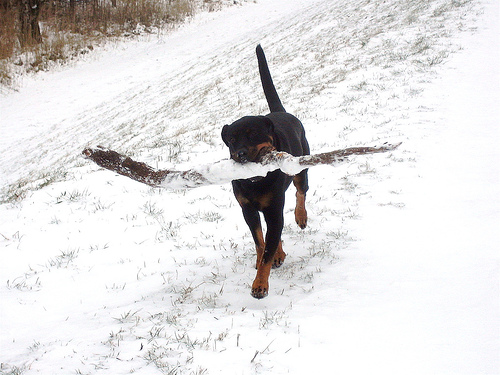

In [7]:
# prompt: write a code that display this image /content/coco_dataset/images/val/386655611.jpg

from IPython.display import Image, display

image_path = "/content/coco_dataset/images/val/386655611.jpg"
display(Image(filename=image_path))


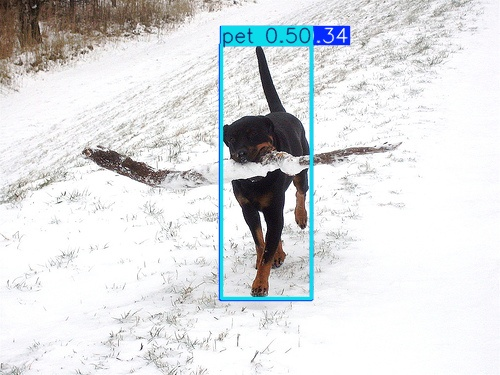

In [8]:
# prompt: write a code that display this image /content/coco_dataset/images/val/386655611.jpg

from IPython.display import Image, display

image_path = "/content/runs/detect/predict/386655611.jpg"
display(Image(filename=image_path))